In [ ]:
!pip install noisereduce
!pip install praat-parselmouth
!pip install --upgrade librosa
!pip install librosa scipy
!pip install pysptk

In [ ]:
import pandas as pd
import numpy as np
import librosa
import parselmouth
from parselmouth.praat import call
import scipy.stats as stats
import scipy
import pysptk
from scipy.io import wavfile
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import os

Mounted at /content/drive


## Load File

In [ ]:
import os
import pandas as pd

def load_labels(base_path):
    data = []
    sessions = ['Session1', 'Session2', 'Session3', 'Session4', 'Session5']

    # Iterate over each session
    for session in sessions:
        # Define the path to the labels folder
        label_path = os.path.join(base_path, session, 'dialog', 'EmoEvaluation', 'Categorical')

        # Check if the path exists
        if not os.path.exists(label_path):
            print(f"Path does not exist: {label_path}")
            continue

        # Loop through each text file in the folder
        for filename in os.listdir(label_path):
            file_path = os.path.join(label_path, filename)
            if filename.endswith('.txt'):
                # Open and process each file
                with open(file_path, 'r', encoding='utf-8') as file:
                    for line in file:
                        parts = line.strip().split(':')
                        if len(parts) == 2:
                            speaker_id = parts[0].strip()
                            emotion = parts[1].split(';')[0].strip()
                            data.append({'Speaker_id': speaker_id, 'Emotion': emotion})
                            #if speaker_id == 'Ses01M_impro03_M000':
                            #  print(session, filename, speaker_id,emotion)
    # Create a DataFrame from the collected data
    label_df = pd.DataFrame(data, columns=['Speaker_id', 'Emotion'])
    return label_df

# Example usage
base_path = '/content/drive/Shared drives/CS298/CS 297/IEMOCAP'
labels_df = load_labels(base_path)
labels_df


,Speaker_id,Emotion
0,Ses01M_script02_2_F000,Neutral state
1,Ses01M_script02_2_F001,Frustration
2,Ses01M_script02_2_F002,Frustration
3,Ses01M_script02_2_F003,Frustration
4,Ses01M_script02_2_F004,Neutral state
...,...,...
28840,Ses05M_impro04_M037,Anger
28841,Ses05M_impro04_M038,Frustration
28842,Ses05M_impro04_M039,Frustration
28843,Ses05M_impro04_M040,Anger


In [ ]:
# Define a mapping from original labels to new labels
emotion_mapping = {
    'Neutral state': 'neutral',
    'Frustration': 'sad',
    'Anger': 'angry',
    'Surprise': None,  # Assuming 'Surprise' to 'neutral' if not sure where to map
    'Disgust': None,  # Mapping 'Disgust' to 'angry' or consider removing if not relevant
    'Other': None,  # Remove 'Other' or map if it can be categorized
    'Sadness': 'sad',
    'Fear': None,  # Assuming 'Fear' to 'neutral' or map to 'angry' based on context
    'Happiness': 'happy',
    'Excited': 'happy'
}

# Apply the mapping to the Emotion column
labels_df['Emotion'] = labels_df['Emotion'].map(emotion_mapping)

# Remove any rows with None as Emotion (unmapped categories)
labels_df = labels_df.dropna(subset=['Emotion'])
labels_df

,Speaker_id,Emotion
0,Ses01M_script02_2_F000,neutral
1,Ses01M_script02_2_F001,sad
2,Ses01M_script02_2_F002,sad
3,Ses01M_script02_2_F003,sad
4,Ses01M_script02_2_F004,neutral
...,...,...
28840,Ses05M_impro04_M037,angry
28841,Ses05M_impro04_M038,sad
28842,Ses05M_impro04_M039,sad
28843,Ses05M_impro04_M040,angry


In [ ]:
import os
import pandas as pd

# Base path to the session folders
base_path = '/content/drive/Shared drives/CS298/CS 297/IEMOCAP'

# Initialize an empty list to store the data
data = []

# Loop through each session folder
for session in range(1, 6):
    # Define the path to the transcriptions folder
    transcription_path = f'{base_path}/Session{session}/dialog/transcriptions'
    print(transcription_path)
    # Loop through each transcription file in the folder
    for filename in os.listdir(transcription_path):
        # Check if the file is a text file
        if filename.endswith('.txt'):
            # Open the text file
            with open(os.path.join(transcription_path, filename), 'r') as file:
                # Read the file line by line
                for line in file:
                    # Split the line at the ':'
                    parts = line.strip().split(':')
                    if len(parts) == 2:
                        # Extract speaker_id and transcript
                        speaker_id = parts[0].split(' ')[0]
                        transcript = parts[1].strip()
                        if transcript == 'The craziest thing just happened to me.':
                          print(session, filename, speaker_id)
                        # Append to the list
                        data.append([speaker_id, transcript])

# Create a DataFrame from the collected data
df = pd.DataFrame(data, columns=['Speaker_id', 'Transcript'])

# Display the DataFrame


/content/drive/Shared drives/CS298/CS 297/IEMOCAP/Session1/dialog/transcriptions
1 Ses01M_impro03.txt Ses01M_impro03_M000
/content/drive/Shared drives/CS298/CS 297/IEMOCAP/Session2/dialog/transcriptions
/content/drive/Shared drives/CS298/CS 297/IEMOCAP/Session3/dialog/transcriptions
/content/drive/Shared drives/CS298/CS 297/IEMOCAP/Session4/dialog/transcriptions
/content/drive/Shared drives/CS298/CS 297/IEMOCAP/Session5/dialog/transcriptions


In [ ]:
df.head()

,Speaker_id,Transcript
0,Ses01M_impro03_M000,The craziest thing just happened to me.
1,Ses01M_impro03_F000,What?
2,Ses01M_impro03_M001,This girl; she just offered me fifty thousand ...
3,Ses01M_impro03_F001,[BREATHING]
4,Ses01M_impro03_M002,Yeah.


In [ ]:
labels_df[labels_df['Speaker_id'] == 'Ses05M_impro04_M040']

,Speaker_id,Emotion
22845,Ses05M_impro04_M040,angry
25565,Ses05M_impro04_M040,sad
28843,Ses05M_impro04_M040,angry


In [ ]:
merged_df = pd.merge(df, labels_df, on='Speaker_id', how='inner')[['Speaker_id','Transcript','Emotion']]
merged_df

,Speaker_id,Transcript,Emotion
0,Ses01M_impro03_M000,The craziest thing just happened to me.,happy
1,Ses01M_impro03_M000,The craziest thing just happened to me.,happy
2,Ses01M_impro03_M000,The craziest thing just happened to me.,happy
3,Ses01M_impro03_F000,What?,happy
4,Ses01M_impro03_F000,What?,neutral
...,...,...,...
27283,Ses05M_script02_2_F038,Or not.,happy
27284,Ses05M_script02_2_F038,Or not.,happy
27285,Ses05M_script02_2_M040,Or not.,neutral
27286,Ses05M_script02_2_M040,Or not.,happy


In [ ]:
def most_common_emotion(series):
    counts = series.value_counts()
    if len(counts) == 1:  # Only one type of emotion present
        return counts.idxmax()
    elif counts.iloc[0] > counts.iloc[1]:  # More than one type, and the first is most common
        return counts.idxmax()
    else:
        return series.iloc[0]  # If a

# Group by Speaker_id and Transcript (assuming Transcript is a column in merged_df)
result_df = merged_df.groupby(['Speaker_id', 'Transcript']).agg({'Emotion': most_common_emotion}).reset_index()


In [ ]:
result_df

,Speaker_id,Transcript,Emotion
0,Ses01F_impro01_F000,Excuse me.,neutral
1,Ses01F_impro01_F001,Yeah.,neutral
2,Ses01F_impro01_F002,Is there a problem?,neutral
3,Ses01F_impro01_F003,You did.,neutral
4,Ses01F_impro01_F004,You were standing at the beginning and you dir...,neutral
...,...,...,...
9996,Ses05M_script03_2_M041,"You are a vile tempered, wicked living, evil l...",angry
9997,Ses05M_script03_2_M042,"Oh, you're not going like this.",angry
9998,Ses05M_script03_2_M043,"[GARBAGE] No, you're not.",angry
9999,Ses05M_script03_2_M044,oh! Marry you again? I wouldn't marry you agai...,angry


In [ ]:
result_df[result_df['Speaker_id'] == 'Ses01F_impro07_M001']

,Speaker_id,Transcript,Emotion
321,Ses01F_impro07_M001,Yeah. That is so awesome.,happy


In [ ]:
import pandas as pd
import re


# Function to preprocess text
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphanumeric characters (keeping spaces)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text

# Apply the preprocessing function to the 'Transcript' column
result_df['Transcript'] = result_df['Transcript'].apply(preprocess_text)

# Display the first few entries to verify changes
result_df.head()


,Speaker_id,Transcript,Emotion
0,Ses01F_impro01_F000,excuse me,neutral
1,Ses01F_impro01_F001,yeah,neutral
2,Ses01F_impro01_F002,is there a problem,neutral
3,Ses01F_impro01_F003,you did,neutral
4,Ses01F_impro01_F004,you were standing at the beginning and you dir...,neutral


In [ ]:
# Recalculate the emotion counts
emotion_counts = result_df['Emotion'].value_counts()

# Print the updated counts
for emotion, count in emotion_counts.items():
    print(f"{emotion}: {count}")

sad: 3781
happy: 2642
neutral: 2116
angry: 1462


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming 'merged_df' is your DataFrame containing the 'Emotion' and 'Transcript' columns

# Text preprocessing
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X = vectorizer.fit_transform(result_df['Transcript'])
y = result_df['Emotion']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Logistic Regression model
model = LogisticRegression(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Predict the test set results
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.5582208895552224
              precision    recall  f1-score   support

       angry       0.63      0.33      0.44       293
       happy       0.60      0.63      0.62       509
     neutral       0.44      0.25      0.32       432
         sad       0.55      0.77      0.64       767

    accuracy                           0.56      2001
   macro avg       0.56      0.50      0.50      2001
weighted avg       0.55      0.56      0.54      2001



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=1000)

# Apply the vectorizer to the Transcript column
X = vectorizer.fit_transform(result_df['Transcript'])
y =result_df['Emotion']

# Proceed with splitting the data and training the model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression(random_state=42, multi_class='multinomial', solver='lbfgs')
model.fit(X_train, y_train)

# Predict the emotions on the test set
y_pred = model.predict(X_test)

# Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.545727136431784
              precision    recall  f1-score   support

       angry       0.58      0.36      0.44       293
       happy       0.63      0.59      0.61       509
     neutral       0.43      0.25      0.31       432
         sad       0.53      0.76      0.62       767

    accuracy                           0.55      2001
   macro avg       0.54      0.49      0.50      2001
weighted avg       0.54      0.55      0.53      2001



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Text tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(result_df['Transcript'])
sequences = tokenizer.texts_to_sequences(result_df['Transcript'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')

# Label encoding
encoder = LabelEncoder()
y = encoder.fit_transform(result_df['Emotion'])
y = tf.keras.utils.to_categorical(y)  # Convert labels to one-hot encoding

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)


In [ ]:
result_df['Transcript'].apply(lambda x: len(x.split())).max()

100

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Text tokenization and padding
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(result_df['Transcript'])
sequences = tokenizer.texts_to_sequences(result_df['Transcript'])
padded_sequences = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')
# Generate an array of indices the same length as dataset
indices = np.arange(padded_sequences.shape[0])
# Label encoding
encoder = LabelEncoder()
y = encoder.fit_transform(result_df['Emotion'])
y = tf.keras.utils.to_categorical(y)  # Convert labels to one-hot encoding

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(padded_sequences, y, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    padded_sequences, y, indices, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

from tensorflow.keras.optimizers import Adam

# Initialize the Adam optimizer with a custom learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Model definition remains the same
'''
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=85),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])
'''
model = Sequential([
    Embedding(input_dim=10000, output_dim=64, input_length=85),
    LSTM(64),  # Using a single LSTM layer
    Dense(32, activation='relu'),
    Dense(y.shape[1], activation='softmax')  # Output layer with one neuron per class
])

# Compile the model with the custom optimizer
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Training the model with adjusted learning rate
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), batch_size=32)



Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - accuracy: 0.3586 - loss: 1.3383 - val_accuracy: 0.3833 - val_loss: 1.3322
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.3772 - loss: 1.3284 - val_accuracy: 0.3833 - val_loss: 1.3288
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.3855 - loss: 1.3282 - val_accuracy: 0.3833 - val_loss: 1.3301
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.3719 - loss: 1.3344 - val_accuracy: 0.3833 - val_loss: 1.3285
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.3745 - loss: 1.3315 - val_accuracy: 0.3833 - val_loss: 1.3294
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 59ms/step - accuracy: 0.3864 - loss: 1.3245 - val_accuracy: 0.3833 - val_loss: 1.3299
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.3833 - loss: 1.3262 - val_accuracy: 0.3833 - val_loss: 1.3287
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.3747 - loss: 1.3344 - val_accurac

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3881 - loss: 1.3260
Test Accuracy: 0.3833083510398865
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step
F1 Score: 0.2124259402090862
Confusion Matrix:
 [[  0   0   0 293]
 [  0   0   0 509]
 [  0   0   0 432]
 [  0   0   0 767]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       293
           1       0.00      0.00      0.00       509
           2       0.00      0.00      0.00       432
           3       0.38      1.00      0.55       767

    accuracy                           0.38      2001
   macro avg       0.10      0.25      0.14      2001
weighted avg       0.15      0.38      0.21      2001



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


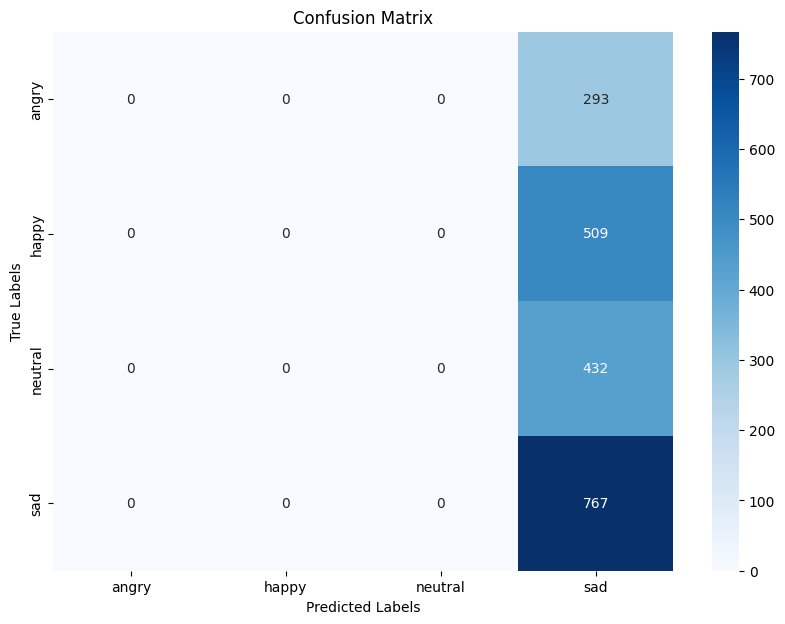

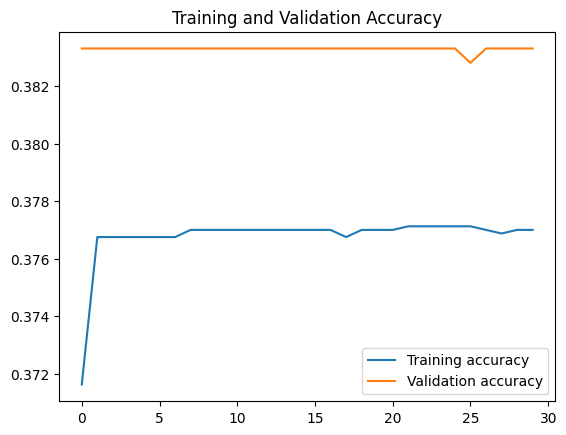

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical

def evaluate_model(model, X_test, y_test, history, class_labels):
    # Evaluate the model on the test data
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("Test Accuracy:", test_acc)

    # Predict the test set results for F1 and Confusion Matrix
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Compute the F1 Score
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    print("F1 Score:", f1)

    # Generate and display the confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    print("Confusion Matrix:\n", cm)

    # Classification report
    print(classification_report(y_true_classes, y_pred_classes))

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

# Example of using the function
# Assuming 'model', 'X_test', 'y_test', 'history', and 'encoder.classes_' are defined and available
evaluate_model(model, X_test, y_test, history, encoder.classes_)


In [ ]:
def model_1(vocab_size, output_size):
    tf.random.set_seed(42)
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=40, input_length=85),
        Bidirectional(LSTM(100)),
        Dense(output_size, activation='softmax')
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Assuming vocab_size from tokenizer and output_size from label_encoder
vocab_size = 10000  # or len(tokenizer.word_index) + 1
output_size = len(encoder.classes_)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)
# Initialize the model
model = model_1(vocab_size, output_size)

# Train the model
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test),
                    batch_size=32)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 192ms/step - accuracy: 0.3925 - loss: 1.3130 - val_accuracy: 0.4948 - val_loss: 1.1520
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 32s 130ms/step - accuracy: 0.5526 - loss: 1.0714 - val_accuracy: 0.5527 - val_loss: 1.0481
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.6262 - loss: 0.9206 - val_accuracy: 0.5587 - val_loss: 1.0509
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 131ms/step - accuracy: 0.6552 - loss: 0.8443 - val_accuracy: 0.5632 - val_loss: 1.0873
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 146ms/step - accuracy: 0.6775 - loss: 0.7879 - val_accuracy: 0.5672 - val_loss: 1.1097
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 38s 133ms/step - accuracy: 0.6983 - loss: 0.7418 - val_accuracy: 0.5752 - val_loss: 1.1178
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 33s 132ms/step - accuracy: 0.7130 - loss: 0.7059 - val_accuracy: 0.5577 - val_loss: 1.1587
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 130ms/step - accuracy: 0.7242 - loss: 0.6723 - val

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5326 - loss: 2.1994
Test Accuracy: 0.544727623462677
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step
F1 Score: 0.5393584781896709
Confusion Matrix:
 [[134  18  30 111]
 [ 30 315  64 100]
 [ 51  76 136 169]
 [ 90  65 107 505]]
              precision    recall  f1-score   support

           0       0.44      0.46      0.45       293
           1       0.66      0.62      0.64       509
           2       0.40      0.31      0.35       432
           3       0.57      0.66      0.61       767

    accuracy                           0.54      2001
   macro avg       0.52      0.51      0.51      2001
weighted avg       0.54      0.54      0.54      2001



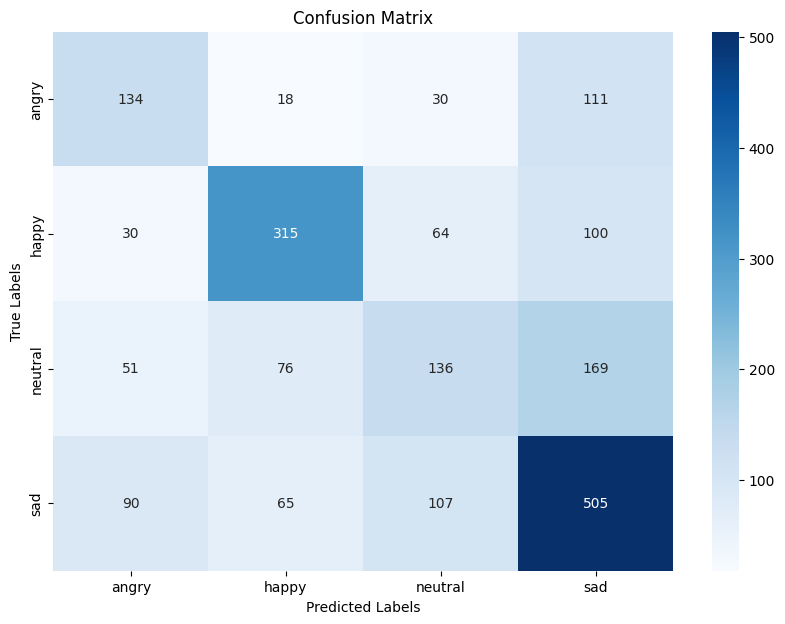

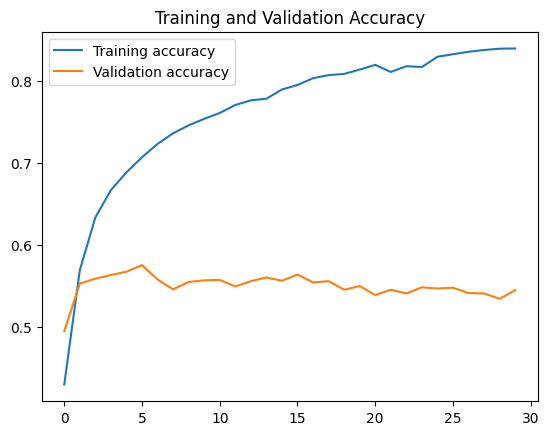

In [ ]:
evaluate_model(model, X_test, y_test, history, encoder.classes_)


### Attention

In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class Attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="normal")
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros")

        super(Attention, self).build(input_shape)

    def call(self, x):
        # Applying the attention mechanism
        e = K.tanh(K.dot(x, self.W) + self.b)
        a = K.softmax(e, axis=1)
        output = x * a

        if self.return_sequences:
            return output

        return K.sum(output, axis=1)


def build_model(vocab_size, output_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=85),
        Bidirectional(LSTM(100, return_sequences=True)),
        Attention(return_sequences=False),  # Use attention mechanism
        Dense(64, activation='relu'),
        Dense(output_size, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# Example usage
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the lowest validation loss
)
model = build_model(vocab_size=10000, output_size=4)
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 155ms/step - accuracy: 0.3764 - loss: 1.3374 - val_accuracy: 0.3833 - val_loss: 1.3338
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.3994 - loss: 1.3053 - val_accuracy: 0.5107 - val_loss: 1.1494
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 158ms/step - accuracy: 0.5626 - loss: 1.0521 - val_accuracy: 0.5432 - val_loss: 1.0549
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 155ms/step - accuracy: 0.6245 - loss: 0.9308 - val_accuracy: 0.5797 - val_loss: 1.0020
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 150ms/step - accuracy: 0.6657 - loss: 0.8428 - val_accuracy: 0.5872 - val_loss: 1.0038
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 162ms/step - accuracy: 0.6914 - loss: 0.7882 - val_accuracy: 0.5822 - val_loss: 1.0287
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.7095 - loss: 0.7367 - val_accuracy: 0.5697 - val_loss: 1.0768
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 78s 150ms/step - accuracy: 0.7289 - loss: 0.6946 - val

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.5297 - loss: 2.9358
Test Accuracy: 0.5412293672561646
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step
F1 Score: 0.5357066170880818
Confusion Matrix:
 [[111  12  28 142]
 [ 20 305  74 110]
 [ 48  73 149 162]
 [ 84  59 106 518]]
              precision    recall  f1-score   support

           0       0.42      0.38      0.40       293
           1       0.68      0.60      0.64       509
           2       0.42      0.34      0.38       432
           3       0.56      0.68      0.61       767

    accuracy                           0.54      2001
   macro avg       0.52      0.50      0.51      2001
weighted avg       0.54      0.54      0.54      2001



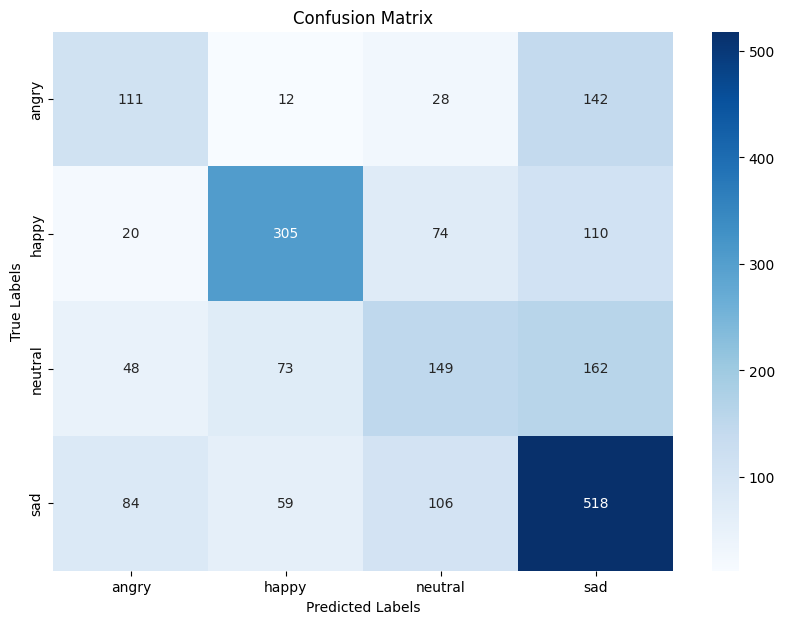

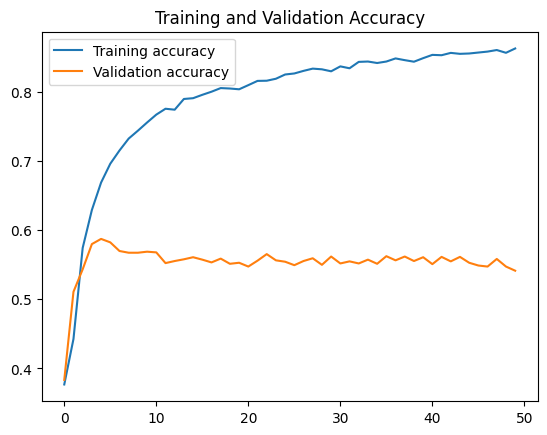

In [ ]:
evaluate_model(model, X_test, y_test, history, encoder.classes_)


In [ ]:
import pandas as pd
import numpy as np
speaker_ids_test = merged_df.iloc[idx_test]['Speaker_id'].tolist()

def evaluate_and_display_predictions_with_transcript_and_speaker(model, X_test, y_test, idx_test, class_labels, speaker_ids):
    # Predict the test set results
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Fetch transcripts and speaker_ids based on test indices
    transcripts = merged_df.iloc[idx_test]['Transcript'].tolist()

    # Convert numeric labels back to original labels
    predicted_labels = [class_labels[i] for i in y_pred_classes]
    true_labels = [class_labels[i] for i in y_true_classes]

    # Create a DataFrame to display the speaker_id, transcripts, true labels, predicted labels
    results_df = pd.DataFrame({
        'Speaker ID': speaker_ids,
        'Transcript': transcripts,
        'True Label': true_labels,
        'Predicted Label': predicted_labels,
        'Predicted Probability': np.max(y_pred, axis=1)
    })



    return results_df  # Return the DataFrame in case you need it for further analysis

# Usage of the function
class_labels = encoder.classes_
results_df = evaluate_and_display_predictions_with_transcript_and_speaker(model, X_test, y_test, idx_test, class_labels, speaker_ids_test)


63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step


In [ ]:
# Display the DataFrame
results_df

,Speaker ID,Transcript,True Label,Predicted Label,Predicted Probability
0,Ses02M_impro01_F015,"I'm sorry, sir.",sad,neutral,0.999326
1,Ses01F_script03_2_F023,Mind your own business.,sad,sad,0.719146
2,Ses01F_script02_2_M048,"Shh. If we're very quiet, the fish might come.",sad,neutral,0.952916
3,Ses01F_script03_2_F036,"I won't. Let go, let go of me. Listen, listen...",happy,neutral,0.999839
4,Ses01M_script01_1_F037,"Oh, must you be inspired.",angry,angry,0.926524
...,...,...,...,...,...
1996,Ses02F_impro07_F027,And you'll be like...,sad,neutral,0.999712
1997,Ses02M_impro05_F024,The airline can't afford to give you everythin...,angry,sad,0.989612
1998,Ses01F_impro02_M005,I don't know how you can be okay with this? I...,neutral,sad,0.855010
1999,Ses02M_script03_2_F001,"Presents, just a trivial little broach.",neutral,sad,0.507683


In [ ]:
merged_df

,Speaker_id,Transcript,Emotion
0,Ses01M_impro03_M000,The craziest thing just happened to me.,happy
1,Ses01M_impro03_M000,The craziest thing just happened to me.,happy
2,Ses01M_impro03_M000,The craziest thing just happened to me.,happy
3,Ses01M_impro03_F000,What?,happy
4,Ses01M_impro03_F000,What?,neutral
...,...,...,...
27283,Ses05M_script02_2_F038,Or not.,happy
27284,Ses05M_script02_2_F038,Or not.,happy
27285,Ses05M_script02_2_M040,Or not.,neutral
27286,Ses05M_script02_2_M040,Or not.,happy


# **Model 2**

In [ ]:
def build_model_2(vocab_size, output_size):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=64, input_length=85, trainable=True),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.3),
        Attention(return_sequences=False),
        Dense(128, activation='relu'),
        Dense(output_size, activation='softmax')
    ])

    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


In [ ]:
model2 = build_model_2(vocab_size=10000, output_size=4)
history = model2.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 85s 318ms/step - accuracy: 0.3750 - loss: 1.3398 - val_accuracy: 0.3833 - val_loss: 1.3335
Epoch 2/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 297ms/step - accuracy: 0.3934 - loss: 1.3099 - val_accuracy: 0.5077 - val_loss: 1.1468
Epoch 3/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 75s 299ms/step - accuracy: 0.5554 - loss: 1.0496 - val_accuracy: 0.5397 - val_loss: 1.0516
Epoch 4/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 297ms/step - accuracy: 0.6113 - loss: 0.9270 - val_accuracy: 0.5757 - val_loss: 1.0205
Epoch 5/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 298ms/step - accuracy: 0.6614 - loss: 0.8418 - val_accuracy: 0.5812 - val_loss: 1.0238
Epoch 6/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 78s 310ms/step - accuracy: 0.6828 - loss: 0.7813 - val_accuracy: 0.5732 - val_loss: 1.0538
Epoch 7/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 306ms/step - accuracy: 0.7018 - loss: 0.7353 - val_accuracy: 0.5737 - val_loss: 1.0963
Epoch 8/50
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 299ms/step - accuracy: 0.7198 - loss: 0.6933 - val

63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.5493 - loss: 3.3502
Test Accuracy: 0.5457271337509155
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step
F1 Score: 0.5432993992196936
Confusion Matrix:
 [[136  21  43  93]
 [ 12 337  79  81]
 [ 43  91 158 140]
 [ 98  92 116 461]]
              precision    recall  f1-score   support

           0       0.47      0.46      0.47       293
           1       0.62      0.66      0.64       509
           2       0.40      0.37      0.38       432
           3       0.59      0.60      0.60       767

    accuracy                           0.55      2001
   macro avg       0.52      0.52      0.52      2001
weighted avg       0.54      0.55      0.54      2001



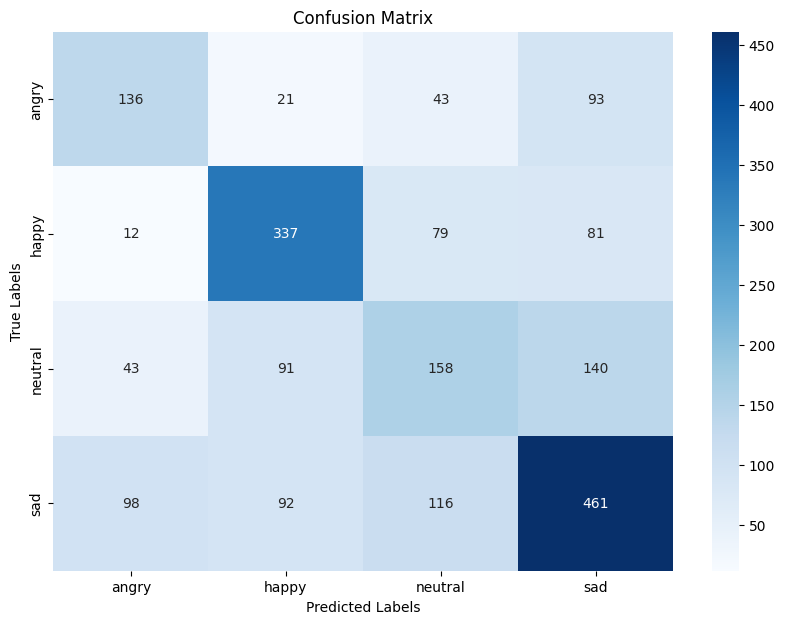

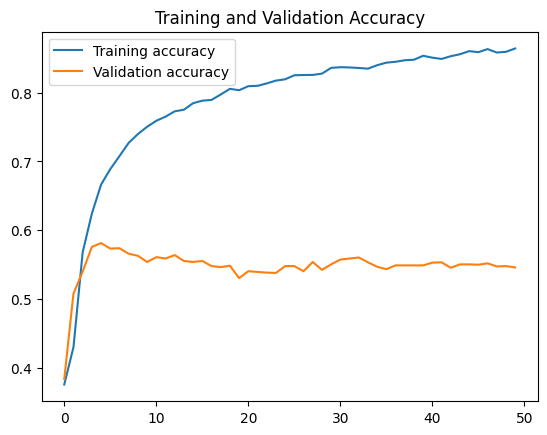

In [ ]:
evaluate_model(model2, X_test, y_test, history, encoder.classes_)
